### Data Loading

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file to explore its content and structure
campaign_data = pd.read_csv('Amazon Ads All.csv')

# Display the first few rows of the dataframe and the column names to understand the dataset
campaign_data.head(), campaign_data.columns

(   ADV_ID    AD_ID         SKU     placement_slot  impressions  clicks  \
 0   84373  6370624  9985955750  offsite_mobileweb         1089       0   
 1   66528  3003509  6064714310  offsite_mobileapp            4       0   
 2   88613  9302679  7428981046    offsite_desktop            4       0   
 3   57975  3325755  7489730099    offsite_desktop           13       0   
 4   13386  6532070  6004552148  offsite_mobileweb          246       0   
 
    auction_cost  adjusted_cost hit_day_utc  \
 0         10.89          8.790    02/05/24   
 1          0.08          0.032    02/05/24   
 2          0.08          0.032    02/05/24   
 3          0.26          0.127    02/05/24   
 4          2.46          1.978    02/05/24   
 
                             targeting_secondary                 vertical  \
 0  category=Automotive Replacement Control Arms               Automotive   
 1              category=Canned & Jarred Seafood  Consumer Packaged Goods   
 2                       category

### CLEANING

In [7]:

# Attempt to parse dates in the '%d/%m/%y' format
campaign_data['hit_day_utc_parsed'] = pd.to_datetime(campaign_data['hit_day_utc'], format='%d/%m/%y', errors='coerce')

# Parse remaining unparsed dates in the '%Y-%m-%d %H:%M:%S' format
mask = campaign_data['hit_day_utc_parsed'].isna()
campaign_data.loc[mask, 'hit_day_utc_parsed'] = pd.to_datetime(campaign_data.loc[mask, 'hit_day_utc'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Check for any remaining non-parsed dates
remaining_non_parsed = campaign_data[campaign_data['hit_day_utc_parsed'].isna()]
if not remaining_non_parsed.empty:
    print("Remaining non-parsed dates:")
    print(remaining_non_parsed)


# Print unique months in the parsed 'hit_day_utc_parsed' column
print("Unique months in 'hit_day_utc_parsed':")
print(campaign_data['hit_day_utc_parsed'].dt.month.unique())

# Extract month and day of the week from parsed dates
campaign_data['month_name'] = campaign_data['hit_day_utc_parsed'].dt.strftime('%B')  # Get month names
campaign_data['day_name'] = campaign_data['hit_day_utc_parsed'].dt.strftime('%A')    # Get day names

# Fill missing values in 'vertical' and 'sub_vertical' with 'Unknown'
campaign_data['vertical'].fillna('Unknown', inplace=True)
campaign_data['sub_vertical'].fillna('Unknown', inplace=True)

# Identify the last 6 columns
last_6_columns = campaign_data.columns[-6:]

# Fill missing values in the last 6 columns with 0
campaign_data[last_6_columns] = campaign_data[last_6_columns].fillna(0)

# Display the cleaned dataset
print("Cleaned Campaign Data Sample:")
print(campaign_data.head())

# Inspect the 'hit_day_utc' column to understand its format
print("Sample of 'hit_day_utc' column:")
print(campaign_data['hit_day_utc'].head(10))

# Filter the data where clicks is at least 1
# campaign_data = campaign_data[campaign_data['clicks'] >= 1] # use for below code blocks when not doing for NTB
# campaign_data = campaign_data[(campaign_data['ntb_view_attributed_units_sold'] > 0)] # use for NTB

Unique months in 'hit_day_utc_parsed':
[5 4 3 2]


/var/folders/80/ghdt2w012_x2yg018vx45m300000gn/T/ipykernel_72166/2532159690.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  campaign_data['vertical'].fillna('Unknown', inplace=True)
/var/folders/80/ghdt2w012_x2yg018vx45m300000gn/T/ipykernel_72166/2532159690.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Cleaned Campaign Data Sample:
   ADV_ID    AD_ID         SKU     placement_slot  impressions  clicks  \
0   84373  6370624  9985955750  offsite_mobileweb         1089       0   
1   66528  3003509  6064714310  offsite_mobileapp            4       0   
2   88613  9302679  7428981046    offsite_desktop            4       0   
3   57975  3325755  7489730099    offsite_desktop           13       0   
4   13386  6532070  6004552148  offsite_mobileweb          246       0   

   auction_cost  adjusted_cost hit_day_utc  \
0         10.89          8.790    02/05/24   
1          0.08          0.032    02/05/24   
2          0.08          0.032    02/05/24   
3          0.26          0.127    02/05/24   
4          2.46          1.978    02/05/24   

                            targeting_secondary  ...  \
0  category=Automotive Replacement Control Arms  ...   
1              category=Canned & Jarred Seafood  ...   
2                       category=Comedy & Humor  ...   
3                  categ

### Predicting impressions with view attributed units sold data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Filter
campaign_data = campaign_data[campaign_data['view_attributed_units_sold'] >= 1]

# Define features and target for adjusted cost
features_cost = ['clicks', 'targeting_secondary', 'placement_slot', 'month_name', 'day_name']
target_cost = 'impressions'

# Prepare the data
X_cost = campaign_data[features_cost]
y_cost = campaign_data[target_cost]

# One-hot encode categorical features and standardize numerical features
preprocessor_cost = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [ 'clicks']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])
    ])

# Define and train 
model_cost = Pipeline(steps=[
    ('preprocessor', preprocessor_cost),
    ('regressor', RandomForestRegressor(random_state=42))
])

X_train_cost, X_test_cost, y_train_cost, y_test_cost = train_test_split(X_cost, y_cost, test_size=0.2, random_state=42)
model_cost.fit(X_train_cost, y_train_cost)

# Predict and evaluate the adjusted cost model
y_pred_cost = model_cost.predict(X_test_cost)
mse_cost = mean_squared_error(y_test_cost, y_pred_cost)
mae_cost = mean_absolute_error(y_test_cost, y_pred_cost)
r2_cost = r2_score(y_test_cost, y_pred_cost)

# Display the evaluation metrics for adjusted cost model
print(f"Adjusted Cost Model - Mean Squared Error: {mse_cost}")
print(f"Adjusted Cost Model - Mean Absolute Error: {mae_cost}")
print(f"Adjusted Cost Model - R-squared: {r2_cost}")

# Get feature names after one-hot encoding
encoded_feature_names_cost = model_cost.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])

# Combine original numerical features with encoded categorical features
all_features_cost = ['clicks'] + list(encoded_feature_names_cost)

# Calculate feature importance
importance_cost = model_cost.named_steps['regressor'].feature_importances_
feature_importance_cost = pd.DataFrame({
    'Feature': all_features_cost,
    'Importance': importance_cost
}).sort_values(by='Importance', ascending=False)

print("Feature Importance for Adjusted Cost Model:")
pd.set_option('display.max_rows', None)
print(feature_importance_cost)

Adjusted Cost Model - Mean Squared Error: 3243257.1161348945
Adjusted Cost Model - Mean Absolute Error: 733.3025594795199
Adjusted Cost Model - R-squared: 0.8460862473104676
Feature Importance for Adjusted Cost Model:
                                               Feature    Importance
973                   placement_slot_offsite_mobileapp  2.339206e-01
920  targeting_secondary_category=Women's Running S...  1.941774e-01
0                                               clicks  9.377072e-02
345     targeting_secondary_category=Foundation Makeup  4.718071e-02
964    targeting_secondary_content-category=Soap Opera  2.720978e-02
976                                month_name_February  2.244998e-02
720  targeting_secondary_category=Sheet & Pillowcas...  2.233319e-02
977                                   month_name_March  2.063859e-02
423        targeting_secondary_category=Home & Kitchen  1.933547e-02
609    targeting_secondary_category=Oral Care Products  1.811813e-02
740  targeting_secondar

### Predicting Impressions - ['clicks'] >= 1]

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Filter
campaign_data = campaign_data[campaign_data['clicks'] >= 1]

# Define features and target for adjusted cost
features_cost = ['clicks', 'targeting_secondary', 'placement_slot', 'month_name', 'day_name']
target_cost = 'impressions'

# Prepare the data
X_cost = campaign_data[features_cost]
y_cost = campaign_data[target_cost]

# One-hot encode categorical features and standardize numerical features
preprocessor_cost = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [ 'clicks']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])
    ])

# Define and train 
model_cost = Pipeline(steps=[
    ('preprocessor', preprocessor_cost),
    ('regressor', RandomForestRegressor(random_state=42))
])

X_train_cost, X_test_cost, y_train_cost, y_test_cost = train_test_split(X_cost, y_cost, test_size=0.2, random_state=42)
model_cost.fit(X_train_cost, y_train_cost)

# Predict and evaluate the adjusted cost model
y_pred_cost = model_cost.predict(X_test_cost)
mse_cost = mean_squared_error(y_test_cost, y_pred_cost)
mae_cost = mean_absolute_error(y_test_cost, y_pred_cost)
r2_cost = r2_score(y_test_cost, y_pred_cost)

# Display the evaluation metrics for adjusted cost model
print(f"Adjusted Cost Model - Mean Squared Error: {mse_cost}")
print(f"Adjusted Cost Model - Mean Absolute Error: {mae_cost}")
print(f"Adjusted Cost Model - R-squared: {r2_cost}")

# Get feature names after one-hot encoding
encoded_feature_names_cost = model_cost.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])

# Combine original numerical features with encoded categorical features
all_features_cost = ['clicks'] + list(encoded_feature_names_cost)

# Calculate feature importance
importance_cost = model_cost.named_steps['regressor'].feature_importances_
feature_importance_cost = pd.DataFrame({
    'Feature': all_features_cost,
    'Importance': importance_cost
}).sort_values(by='Importance', ascending=False)

print("Feature Importance for Adjusted Cost Model:")
pd.set_option('display.max_rows', None)
print(feature_importance_cost)

Adjusted Cost Model - Mean Squared Error: 1748221.0571435709
Adjusted Cost Model - Mean Absolute Error: 542.5725296387511
Adjusted Cost Model - R-squared: 0.9221815258618612
Feature Importance for Adjusted Cost Model:
                                               Feature    Importance
0                                               clicks  2.472622e-01
971                     placement_slot_offsite_desktop  1.693471e-01
923  targeting_secondary_category=Women's Running S...  7.807349e-02
742  targeting_secondary_category=Sheet & Pillowcas...  4.936104e-02
490     targeting_secondary_category=Kids' Electronics  3.996696e-02
755  targeting_secondary_category=Single-Serve Coff...  2.732934e-02
235  targeting_secondary_category=Desk Accessories ...  1.940416e-02
981                                    day_name_Sunday  1.887196e-02
975                                month_name_February  1.870465e-02
343     targeting_secondary_category=Foundation Makeup  1.822001e-02
673  targeting_secondar

In [9]:
feature_importance_cost.head(20)

Feature  Importance
0                                               clicks    0.247262
971                     placement_slot_offsite_desktop    0.169347
923  targeting_secondary_category=Women's Running S...    0.078073
742  targeting_secondary_category=Sheet & Pillowcas...    0.049361
490     targeting_secondary_category=Kids' Electronics    0.039967
755  targeting_secondary_category=Single-Serve Coff...    0.027329
235  targeting_secondary_category=Desk Accessories ...    0.019404
981                                    day_name_Sunday    0.018872
975                                month_name_February    0.018705
343     targeting_secondary_category=Foundation Makeup    0.018220
673  targeting_secondary_category=Pipe Fittings & P...    0.017673
706  targeting_secondary_category=Probiotic Nutriti...    0.016664
976                                   month_name_March    0.013956
376        targeting_secondary_category=Golf Equipment    0.013372
402  targeting_secondary_category=Hair Styling Prod...    0.011528
973                   placement_slot_offsite_mobileweb    0.010715
946  targeting_secondary_content-category=Action/Ad...    0.010388
983                                   day_name_Tuesday    0.010362
982                                  day_name_Thursday    0.009975
974                                   month_name_April    0.009938

### Predicting NTB view sold items as target

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Filter
campaign_data = campaign_data[(campaign_data['ntb_view_attributed_units_sold'] > 0)]

# Attempt to parse dates in the '%d/%m/%y' format
campaign_data['hit_day_utc_parsed'] = pd.to_datetime(campaign_data['hit_day_utc'], format='%d/%m/%y', errors='coerce')

# Parse remaining unparsed dates in the '%Y-%m-%d %H:%M:%S' format
mask = campaign_data['hit_day_utc_parsed'].isna()
campaign_data.loc[mask, 'hit_day_utc_parsed'] = pd.to_datetime(campaign_data.loc[mask, 'hit_day_utc'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Check for any remaining non-parsed dates
remaining_non_parsed = campaign_data[campaign_data['hit_day_utc_parsed'].isna()]
if not remaining_non_parsed.empty:
    print("Remaining non-parsed dates:")
    print(remaining_non_parsed)


# Extract month and day of the week from parsed dates
campaign_data['month_name'] = campaign_data['hit_day_utc_parsed'].dt.strftime('%B')  # Get month names
campaign_data['day_name'] = campaign_data['hit_day_utc_parsed'].dt.strftime('%A')    # Get day names

# Fill missing values
campaign_data.fillna({
    'vertical': 'unknown',
    'sub_vertical': 'unknown',
    'ntb_click_attributed_units_sold': 0,
    'ntb_view_attributed_units_sold': 0,
    'ntb_click_attributed_orders': 0,
    'ntb_view_attributed_orders': 0,
    'view_attributed_units_sold': 0,
    'view_attributed_orders': 0
}, inplace=True)

# Filter data for NTB reach
ntb_data = campaign_data[(campaign_data['ntb_view_attributed_units_sold'] > 0)]

# Define features and target for NTB reach
features_ntb = ['targeting_secondary', 
                'placement_slot', 'month_name', 'day_name']
target_ntb = 'impressions'

# Prepare the data
X_ntb = ntb_data[features_ntb]
y_ntb = ntb_data[target_ntb]

# One-hot encode categorical features
preprocessor_ntb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])
    ],
    remainder='passthrough'
)

# Define and train the Gradient Boosting Regressor for NTB reach
model_ntb = Pipeline(steps=[
    ('preprocessor', preprocessor_ntb),
    ('regressor', RandomForestRegressor(random_state=42))
])

X_train_ntb, X_test_ntb, y_train_ntb, y_test_ntb = train_test_split(X_ntb, y_ntb, test_size=0.2, random_state=42)
model_ntb.fit(X_train_ntb, y_train_ntb)

# Predict and evaluate the NTB reach model
y_pred_ntb = model_ntb.predict(X_test_ntb)
mse_ntb = mean_squared_error(y_test_ntb, y_pred_ntb)
mae_ntb = mean_absolute_error(y_test_ntb, y_pred_ntb)
r2_ntb = r2_score(y_test_ntb, y_pred_ntb)

# Display the evaluation metrics for NTB reach model
print(f"NTB Reach Model - Mean Squared Error: {mse_ntb}")
print(f"NTB Reach Model - Mean Absolute Error: {mae_ntb}")
print(f"NTB Reach Model - R-squared: {r2_ntb}")

# Get feature names after one-hot encoding
all_feature_names = model_ntb.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])
# all_feature_names = np.concatenate((encoded_feature_names, [ 'adjusted_cost']))

# Calculate feature importance
importance_ntb = model_ntb.named_steps['regressor'].feature_importances_
feature_importance_ntb = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance_ntb
}).sort_values(by='Importance', ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
print("Feature Importance for NTB Reach Model:")
print(feature_importance_ntb)


NTB Reach Model - Mean Squared Error: 4553859.613573007
NTB Reach Model - Mean Absolute Error: 904.4715146897321
NTB Reach Model - R-squared: 0.7924186385817332
Feature Importance for NTB Reach Model:
                                                                            Feature  \
909                                                placement_slot_offsite_mobileapp   
859                              targeting_secondary_category=Women's Running Shoes   
319                                  targeting_secondary_category=Foundation Makeup   
673                            targeting_secondary_category=Sheet & Pillowcase Sets   
394                                     targeting_secondary_category=Home & Kitchen   
567                                 targeting_secondary_category=Oral Care Products   
913                                                                month_name_March   
912                                                             month_name_February   
463             

### Optimal Bidding based on Adjusted Cost- subset clicks>1


Taking a subset where clicks > 0 for modeling the optimal bidding strategy. This subset would likely contain data points where the ad has already attracted user interest and clicks, which could provide more meaningful insights into the factors that contribute to higher engagement and conversions.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Filter
campaign_data = campaign_data[campaign_data['clicks'] >= 1]

# Define features and target for adjusted cost
features_cost = [ 'clicks', 'targeting_secondary', 'placement_slot', 'month_name', 'day_name']
target_cost = 'adjusted_cost'

# Prepare the data
X_cost = campaign_data[features_cost]
y_cost = campaign_data[target_cost]

# One-hot encode categorical features and standardize numerical features
preprocessor_cost = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [ 'clicks']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])
    ])

# Define and train 
model_cost = Pipeline(steps=[
    ('preprocessor', preprocessor_cost),
    ('regressor', RandomForestRegressor(random_state=42))
])

X_train_cost, X_test_cost, y_train_cost, y_test_cost = train_test_split(X_cost, y_cost, test_size=0.2, random_state=42)
model_cost.fit(X_train_cost, y_train_cost)

# Predict and evaluate the adjusted cost model
y_pred_cost = model_cost.predict(X_test_cost)
mse_cost = mean_squared_error(y_test_cost, y_pred_cost)
mae_cost = mean_absolute_error(y_test_cost, y_pred_cost)
r2_cost = r2_score(y_test_cost, y_pred_cost)

# Display the evaluation metrics for adjusted cost model
print(f"Adjusted Cost Model - Mean Squared Error: {mse_cost}")
print(f"Adjusted Cost Model - Mean Absolute Error: {mae_cost}")
print(f"Adjusted Cost Model - R-squared: {r2_cost}")

# Get feature names after one-hot encoding
encoded_feature_names_cost = model_cost.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])

# Combine original numerical features with encoded categorical features
all_features_cost = ['clicks'] + list(encoded_feature_names_cost)

# Calculate feature importance
importance_cost = model_cost.named_steps['regressor'].feature_importances_
feature_importance_cost = pd.DataFrame({
    'Feature': all_features_cost,
    'Importance': importance_cost
}).sort_values(by='Importance', ascending=False)

print("Feature Importance for Adjusted Cost Model:")
pd.set_option('display.max_rows', None)
print(feature_importance_cost)

Adjusted Cost Model - Mean Squared Error: 161.94654836115376
Adjusted Cost Model - Mean Absolute Error: 5.078256484168313
Adjusted Cost Model - R-squared: 0.9018571207578389
Feature Importance for Adjusted Cost Model:
                                                                            Feature  \
0                                                                            clicks   
971                                                  placement_slot_offsite_desktop   
490                                  targeting_secondary_category=Kids' Electronics   
923                              targeting_secondary_category=Women's Running Shoes   
742                            targeting_secondary_category=Sheet & Pillowcase Sets   
975                                                             month_name_February   
755                targeting_secondary_category=Single-Serve Coffee Capsules & Pods   
981                                                                 day_name_Sunday   

In [19]:
pd.set_option('display.max_colwidth', 50)
print(feature_importance_cost)

                                               Feature    Importance
0                                               clicks  2.094554e-01
971                     placement_slot_offsite_desktop  1.304008e-01
490     targeting_secondary_category=Kids' Electronics  8.326732e-02
923  targeting_secondary_category=Women's Running S...  5.834613e-02
742  targeting_secondary_category=Sheet & Pillowcas...  3.728180e-02
975                                month_name_February  2.379253e-02
755  targeting_secondary_category=Single-Serve Coff...  2.338897e-02
981                                    day_name_Sunday  2.176936e-02
706  targeting_secondary_category=Probiotic Nutriti...  1.733853e-02
673  targeting_secondary_category=Pipe Fittings & P...  1.715826e-02
235  targeting_secondary_category=Desk Accessories ...  1.704812e-02
423    targeting_secondary_category=Health & Household  1.664479e-02
973                   placement_slot_offsite_mobileweb  1.608606e-02
976                               

/var/folders/80/ghdt2w012_x2yg018vx45m300000gn/T/ipykernel_65807/2846929757.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')


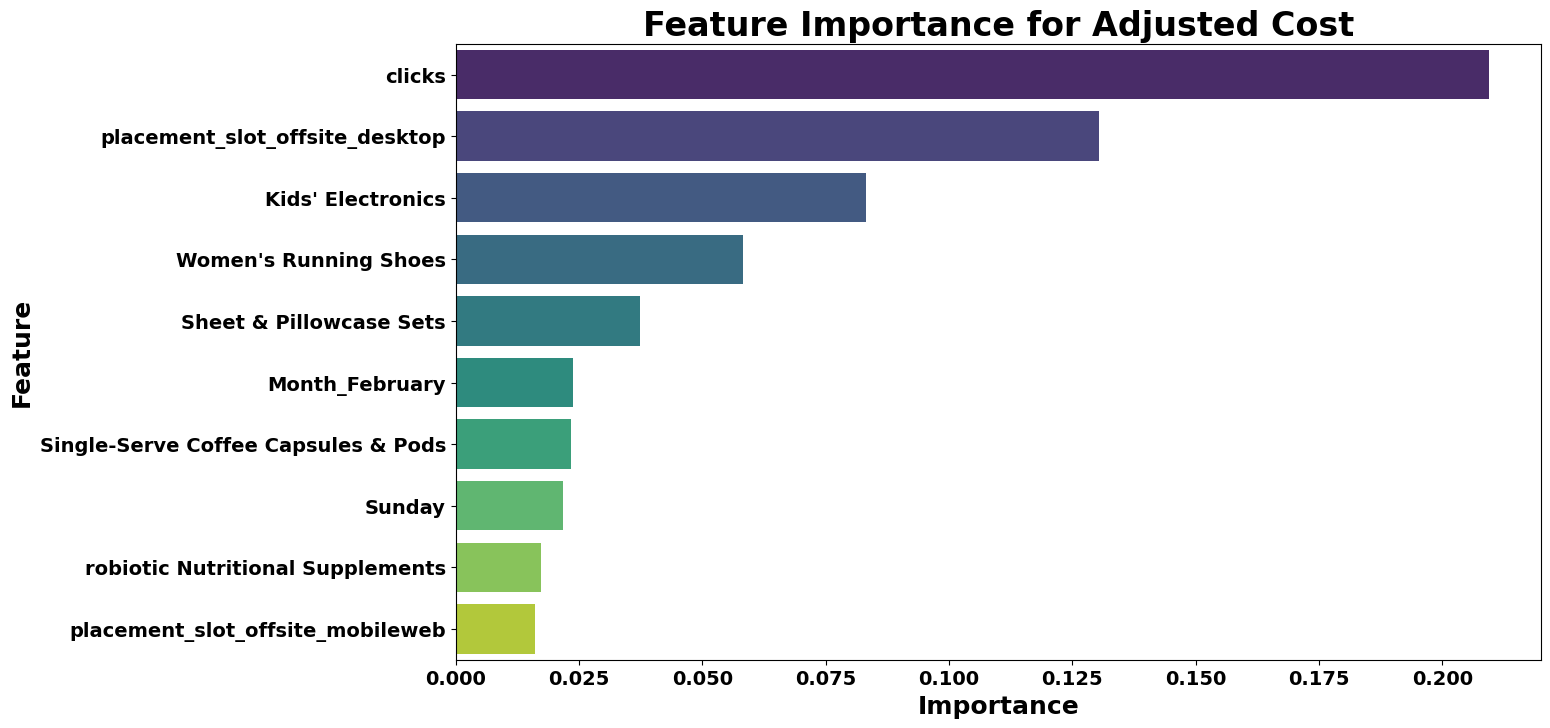

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Feature importance data
feature_importance_data = {
    'Feature': [
        'clicks',
        'placement_slot_offsite_desktop',
        'Kids\' Electronics',
        'Women\'s Running Shoes',
        'Sheet & Pillowcase Sets',
        'Month_February',
        'Single-Serve Coffee Capsules & Pods',
        'Sunday',
        'robiotic Nutritional Supplements',
        'placement_slot_offsite_mobileweb'
    ],
    'Importance': [
        0.209455, 0.130401, 0.083267, 0.058346, 0.037282, 0.023793, 
        0.023389, 0.021769, 0.017339, 0.016086
    ]
}

# Create DataFrame
df_importance = pd.DataFrame(feature_importance_data)

# Plot feature importance
plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')
plt.title('Feature Importance for Adjusted Cost', fontsize=24, fontweight='bold')
plt.xlabel('Importance', fontsize=18, fontweight='bold')
plt.ylabel('Feature', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.show()
